In [ ]:
import pandas as pd
from itertools import product
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import math
import random

In [ ]:
# load in map layers excel sheet
fpath = "map_layers.xlsx"
wb = openpyxl.load_workbook(fpath)
# separate layers for cell tuples
flood_layer, land_layer = wb['n'], wb['l']
crossover_inclusion = wb['i']


def wb_to_array(layer):
    cells = [] # flood risk high/low
    for rows in layer.iter_rows():
        row_cells = []
        for cell in rows:
            row_cells.append(cell.value)
        cells.append(tuple(row_cells))
    
    return np.array(cells)

# flood risk
flood_layer = wb['n']
n_cells = wb_to_array(flood_layer)
# land type
land_layer = wb['l']
l_cells = wb_to_array(land_layer)
# if crossover applicable
crossover_inclusion = wb['i']
i_cells = wb_to_array(crossover_inclusion)

# NJ transit station and light rail
transportation = [[1,5],[2,4],[2,5],[3,4],[3,5]] + [
                [i,0] for i in range(28,37)] + [[i,1] for i in range(28,36)]

grid_size = np.array(i_cells).shape

idx = grid_size[0]
cols = grid_size[1]
n_samples = idx*cols
center_pt = (idx//2, cols//2)

land_codes = {
    'Ignore': 0,            'Recreation': 6,
    'Water': 1,             'Hospital': 7,
    'Undecided': 2,         'Fire Station': 8,
    'University': 3,        'Commercial': 9,
    'Industrial': 4,        'Waterfront': 10,
    'Residential': 5
             }


In [ ]:
    
def show_land_map(l_cells, flood=False):
    # Create the colormap
    cmap = mcolors.ListedColormap(['whitesmoke', 'aqua', 'grey', 'firebrick', 'gold',
                                  'limegreen', 'darkgreen', 'orange', 'red', 'blue', 'hotpink'])

    patches = [mpatches.Patch(color=cmap(v), label=k) for k,v in land_codes.items()]
    plt.legend(handles=patches, loc=2, bbox_to_anchor=(1.01,1))

    # Plot the data
    plt.imshow(l_cells, cmap=cmap, aspect='auto')
    plt.title('Hoboken Distribution of Land by Type')

    plt.show()

    if flood == True:
       # Define the color map
        flood_colors = {
            'Ignore': -1, 
            'Low Risk': 0, 
            'High Risk': 1
        }
        cmap = mcolors.ListedColormap(['white', 'lightgrey', 'royalblue'])

        # Plot the data
        plt.imshow(n_cells, cmap=cmap, aspect='auto')
        plt.title('Hoboken Flood Risk, High or Low')

        plt.show()
        
# show_land_map(l_cells, flood=True)

In [ ]:
def crossover_event(parent1, parent2, crossover_rate):
    if random.random() < crossover_rate:
        # Select two random crossover points
        xover1 = random.randint(0, len(parent1) - 1)
        xover2 = random.randint(xover1, len(parent1))
        # Perform the two-point crossover to get offspring
        xover_slice = parent1[xover1:xover2]
        parent1[xover1:xover2] = parent2[xover1:xover2]
        parent2[xover1:xover2] = xover_slice
        
    return [parent1, parent2]

def mutation_event(mutation_chance, mutation_rate):
    children = []
    for chance,child in mutation_chance:
        if chance < mutation_rate:
            # if random chance is less than mutation rate
            index1, index2 = random.sample(range(len(child)), 2)
            val1, val2 = child[index1], child[index2]
            # switch two random "alleles"
            child[index1] = val2
            child[index2] = val1
        # append mutated children, or same children if chance > mutation_rate
        children.append(child)
    return children[0],children[1]

def init_population(i_cells, l_cells, size=100):
    # convert any land cells not eligible for crossover to zero for now
    population = np.copy(i_cells)
    
    population[np.where(population==1)] = l_cells[np.where(population==1)]
    population = population.reshape(n_samples,)
    # make a vector of only eligible cells
    eligible = [4,5,6,9]

    undecided = np.where(population==2)[0]
    choose_pop = lambda sz: np.random.choice(
                                [x for x in range(4,10) if x in eligible], 
                                size=sz)

    population[undecided] = choose_pop(len(undecided))
    population = population[population!=0]

    mating_pool = np.array([choose_pop(len(population)) for _ in range(size-1)])
    mating_pool = np.append(mating_pool, [np.array(population)], axis=0)

    return mating_pool

def evo_algorithm(mating_pool, i_cells, l_cells, generations, crossover_rate, mutation_rate, size=100):

    for g in range(generations):
        mating_pairs = np.array_split(mating_pool, size//2)

        next_gen = []
        # perform two-point crossover and/or mutation and generate children
        for parent1,parent2 in mating_pairs:
            children = crossover_event(parent1, parent2, crossover_rate)
            # zip children with mutation chance and return resulting children
            mutation_chance = [round(random.uniform(0, 1), 3), round(random.uniform(0, 1), 3)]
            mutation_chance = list(zip(mutation_chance,children))
            child1, child2 = mutation_event(mutation_chance, mutation_rate)
            # add children to next generation
            next_gen.append(child1)
            next_gen.append(child2)
        # reset population using children
        mating_pool = np.array(next_gen)
        
        replace = np.copy(i_cells)
        all_maps = []
        for i in range(len(mating_pool)):
            new_map = np.copy(l_cells)
            new_map[np.where(replace==1)] = mating_pool[i]
            all_maps.append(new_map)

        all_scores = []
        for maps in all_maps:
            vars_dct = convert_to_chromosome(maps)
            score = eval_fitness(maps,weights['r'],weights['c'],weights['i'])
            all_scores.append(score)
        
        choose_pop = lambda sz: np.random.choice(
                                [x for x in range(4,10) if x in [4,5,6,9]], 
                                size=sz)
        best_scores = np.argsort(all_scores)[::-1] 
        top_50 = best_scores[:50]
        mating_pool = [mating_pool[i].reshape(len(mating_pool[0])) for i in top_50] + \
                        [choose_pop(len(mating_pool[0])) for _ in range(50)]
        
    new_land = mating_pool
    return new_land

In [ ]:

def get_density(padded, pad, cond):
    risk_factor = []
    # iterate through non-padding cells
    for row in range(2,grid_size[0]+2):
        for col in range(2,grid_size[1]+2):
            # get risk values of surrounding cells in padded grid
            risk = [padded[row+2][col], padded[row-2][col]]+[padded[row-1][col-i] for i in [1,0,-1]] + [
            padded[row][col-i] for i in [2,1,-1,-2]] + [padded[row+1][col-i] for i in [1,0,-1]]

            # find length of non-padded risk vector 
            r = np.array(risk)
            length = len(r[r!=pad])

            # calculate fraction of high risk cells
            risk_factor.append(len([i for i in risk if i == cond])/length)
            
    return risk_factor


In [ ]:
# land_colors = {
#     'Ignore': 0,            'Recreation': 6,
#     'Water': 1,             'Hospital': 7,
#     'Undecided': 2,         'Fire Station': 8,
#     'University': 3,        'Commercial': 9,
#     'Industrial': 4,        'Waterfront': 10,
#     'Residential': 5
#              }
# apply padding to prevent errors at grid edges
pad = 2   
padded = np.pad(n_cells, ((2,2),(2,2)), mode='constant', constant_values = pad)
cond = 1
# get ratio of high flood risk:low flood risk based on surrounding cells
flood_risk = get_density(padded, pad, cond) 
flood_risk = np.array(flood_risk).reshape(38,19)

def convert_to_chromosome(l_cells):
    land_code = {r:list() for r in range(11)}
    chromosome = {r:list() for r in range(11)}

    for m,n in product(range(idx),range(cols)):

        code = l_cells[m][n]
        land_code[code].append([m,n])

        if i_cells[m][n] == 1:
            chromosome[code].append([m,n])

    code_len = [len(c) for c in chromosome.values()]
    vars_dct = {'transport':transportation, 'flooding':flood_risk, 
                'center':center_pt, 'code':land_code, 'chromosome':chromosome, 'code_len':code_len}
    
    return vars_dct

vars_dct = convert_to_chromosome(l_cells)
flood_score = lambda land: 1-np.mean([vars_dct['flooding'][i] for i in vars_dct['code'][land]])

In [ ]:

def residential_fitness(l_cells,r_w,vars_dct):
    ## RESIDENTIAL ##
    comm_dist_fit = []
    center_fit = []
    ind_dist_fit = []
    park_dist_fit = []
    trans_dist_fit = []
    services_fit = []

    # location of fire stations and hospital 
    services = vars_dct['code'][7]+vars_dct['code'][8]

    # Euclidian distance formula
    distance = lambda c1, c2: np.sqrt((c2[0] - c1[0])**2 + (c2[1] - c1[1])**2)

    # residental cell fitness factors
    for res in vars_dct['code'][5]:
        # distance to city center
        center_fit.append(distance(vars_dct['center'], res))

        # average distance to commercial cell
        commercial_dist = []
        for comm in vars_dct['code'][9]:
            commercial_dist.append(distance(comm,res))
        comm_dist_fit.append(np.mean(commercial_dist))

        # average distance to industrial cell
        industrial_dist = []
        for ind in vars_dct['code'][4]:
            industrial_dist.append(distance(ind,res))
        ind_dist_fit.append(np.mean(commercial_dist))

        # average distance to recreational cell
        park_dist = []
        for park in vars_dct['code'][6]:
            park_dist.append(distance(park,res))
        park_dist_fit.append(np.mean(park_dist))

        # average distance to transportation
        trans_dist = []
        for trans in vars_dct['transport']:
            trans_dist.append(distance(trans,res))
        trans_dist_fit.append(np.mean(trans_dist))

        # average distance to fire and health services
        # more weight for hospital proximity
        serv_dist = []
        for serv in services:
            serv_dist.append(distance(serv, res))
        serv_dist =  serv_dist[:2] + [s*0.75 for s in serv_dist[2:]]
        services_fit.append(np.mean(serv_dist))
    
    res_fitness = [comm_dist_fit, center_fit, ind_dist_fit, 
               park_dist_fit, trans_dist_fit, services_fit]

    res_fitness = [np.mean(fitness/max(fitness)) for fitness in res_fitness]

    # only maximize distance to industrial areas
    to_min = [0,1,3,4,5]
    res_fitness = [1-i if idx in to_min else i for idx,i in enumerate(res_fitness)]
    res_score = np.mean([r*r_w for r_w,r in zip(r_w,res_fitness)])\
    
    return res_score*flood_weight['r']
    

In [ ]:

def commercial_fitness(l_cells,c_w,vars_dct):
    # Euclidian distance formula
    distance = lambda c1, c2: np.sqrt((c2[0] - c1[0])**2 + (c2[1] - c1[1])**2)
    # location of fire stations and hospital 
    services = vars_dct['code'][7]+vars_dct['code'][8]
    pad = -1
    cond = 9
    comm_padded = np.pad(l_cells, ((2,2),(2,2)), mode='constant', constant_values = pad)
    # commercial cells fitness
    comm_dens_fit = get_density(comm_padded, pad, cond) 
    water_dist_fit = []
    trans_comm_fit = []
    uni_dist_fit = []
    comm_ind_fit = []

    for comm in vars_dct['code'][9]:
        # avg distance to waterfront
        waterfront = []
        for water in vars_dct['code'][10]:
            waterfront.append(distance(water,comm))
        water_dist_fit.append(np.mean(waterfront))

        # avg distance to transport
        trans_dist = []
        for trans in vars_dct['transport']:
            trans_dist.append(distance(trans,comm))
        trans_comm_fit.append(np.mean(trans_dist))

        # avg distance to university
        university = []
        for uni in vars_dct['code'][3]:
            university.append(distance(uni,comm))
        uni_dist_fit.append(np.mean(university))

        # avg distance to industrial area
        industrial = []
        for ind in vars_dct['code'][4]:
            industrial.append(distance(ind,comm))
        comm_ind_fit.append(np.mean(industrial))

    comm_dens_fit = np.array(comm_dens_fit)
    comm_dens_fit = comm_dens_fit[comm_dens_fit>0]

    comm_fitness = [comm_dens_fit, water_dist_fit, trans_comm_fit, uni_dist_fit, comm_ind_fit]

    comm_fitness = [np.mean(fitness/max(fitness)) for fitness in comm_fitness]

    to_min = [1,2,3]
    comm_fitness = [1-i if idx in to_min else i for idx,i in enumerate(comm_fitness)]

    comm_score = np.mean([i*weight for weight,i in zip(c_w,comm_fitness)])
    
    return comm_score*flood_weight['c']

In [ ]:

# apply padding to prevent errors at grid edges
pad = 2   
padded = np.pad(n_cells, ((2,2),(2,2)), mode='constant', constant_values = pad)
cond = 1
# get ratio of high flood risk:low flood risk based on surrounding cells
flood_risk = get_density(padded, pad, cond) 
flood_risk = np.array(flood_risk).reshape(38,19)

flood_score = lambda land: 1-np.mean([vars_dct['flooding'][i] for i in vars_dct['code'][land]])

flood_weight = {
    'r':flood_score(5)*1,
    'c':flood_score(9)*1.3,
    'i':flood_score(4)*1.8
}



In [ ]:

def industrial_fitness(l_cells,i_w,vars_dct):
    ## INDUSTRIAL ##
    # apply padding to prevent errors at grid edges
    pad = -1
    cond = 4
    ind_padded = np.pad(l_cells, ((2,2),(2,2)), mode='constant', constant_values = pad)
    # industrial cells fitness
    ind_dens_fit = get_density(ind_padded, pad, cond) 
    res_ind_fit = []
    trans_ind_fit = []
    serv_ind_fit = []
    # location of fire stations and hospital 
    services = vars_dct['code'][7]+vars_dct['code'][8]
    # Euclidian distance formula
    distance = lambda c1, c2: np.sqrt((c2[0] - c1[0])**2 + (c2[1] - c1[1])**2)

    for ind in vars_dct['code'][4]:

        # avg distance to residential
        res_dist = []
        for res in vars_dct['code'][5]:
            res_dist.append(distance(res,ind))
        res_ind_fit.append(np.mean(res_dist))

        # avg distance to transport
        trans_dist = []
        for trans in vars_dct['transport']:
            trans_dist.append(distance(trans,ind))
        trans_ind_fit.append(np.mean(trans_dist))

        # average distance to fire and health services
        serv_dist = []
        for serv in services:
            serv_dist.append(distance(serv, ind))
        # put less weight on hosptial distance
        serv_dist = [s*0.5 for s in serv_dist[:2]] + serv_dist[2:]
        serv_ind_fit.append(np.mean(serv_dist))
    
    ind_dens_fit = np.array(ind_dens_fit)
    ind_dens_fit = ind_dens_fit[ind_dens_fit>0]

    ind_fitness = [ind_dens_fit, res_ind_fit, trans_ind_fit, serv_ind_fit]
    ind_fitness = [np.mean(fitness/max(fitness)) for fitness in ind_fitness]

    # only maximize distance to industrial areas
    to_min = [2,3]

    ind_fitness = [1-i if idx in to_min else i for idx,i in enumerate(ind_fitness)]

    ind_score = np.mean([i*i_w for i_w,i in zip(i_w,ind_fitness)])
    return ind_score*flood_weight['i']



In [ ]:
def eval_fitness(l_cells,r_w,c_w,i_w):
    r = residential_fitness(l_cells,r_w,vars_dct)
    c = commercial_fitness(l_cells,c_w,vars_dct)
    i = industrial_fitness(l_cells,i_w,vars_dct)

    score = (r+c+i)/3
    return score

In [ ]:

def find_best_map(r_w,c_w,i_w,gens):
    mating_pool = init_population(i_cells, l_cells, size=100)
    new_land = evo_algorithm(mating_pool, i_cells, l_cells, generations=gens, 
                             crossover_rate=0.7, mutation_rate=0.02, size=100)

    replace = np.copy(i_cells)
    all_maps = []
    for i in range(len(new_land)):
        new_map = np.copy(l_cells)
        new_map[np.where(replace==1)] = new_land[i]
        all_maps.append(new_map)

    all_scores = []
    for maps in all_maps:
        vars_dct = convert_to_chromosome(maps)
        score = eval_fitness(maps,r_w,c_w,i_w)
        all_scores.append(score)
    
    best_scores = np.argsort(all_scores)[::-1]    
    best_map = all_maps[best_scores[0]]
   
    return all_scores[best_scores[0]], best_map, all_scores


In [ ]:

def show_best_map(weights, gens, show_original=False):
    best_score, best_map, all_scores = find_best_map(weights['r'],weights['c'],weights['i'], gens)
    print(f'\nHighest fitness score: {best_score}')
    
    if show_original == True:
        show_land_map(l_cells)
    
    show_land_map(best_map)
    
    return best_map

Weights: {'r': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'c': [1.0, 1.0, 1.0, 1.0, 1.0], 'i': [1.0, 1.0, 1.0, 1.0]}


Highest fitness score: 0.3561458786152669


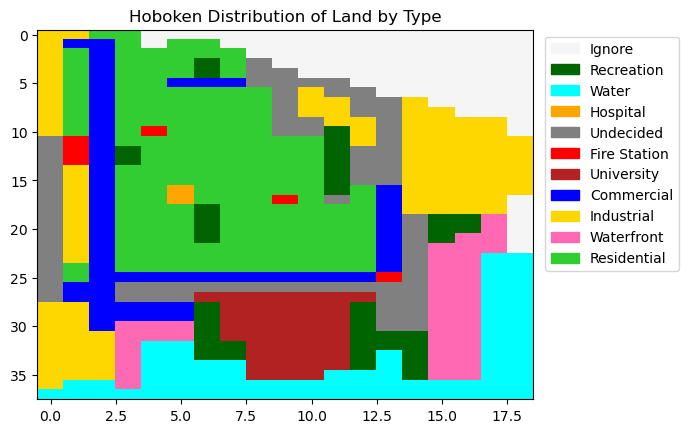

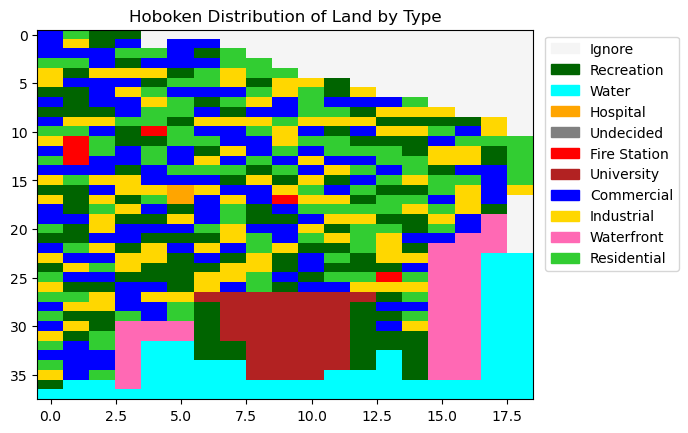

Weights: {'r': [1.969759206169063, 0.5869748483788861, 0.5577472993352424, 1.0062059161715986, 1.2056240699483198, 2.827875326643669], 'c': [2.3201873372870465, 2.118908697436234, 0.427242076371376, 0.620324692707132, 0.5149420729009574], 'i': [1.0965297273433623, 0.40632031606092645, 2.426238075681436, 1.667096061197714]}


Highest fitness score: 0.41625816739383675


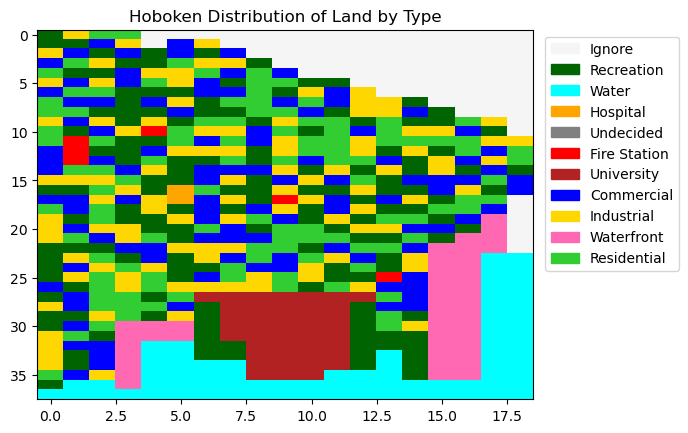

Weights: {'r': [2.9210237504480334, 0.015740753717331413, 1.5660762940019843, 0.8939824828528893, 0.18445018241469469, 1.6429652233565957], 'c': [2.855531914834777, 0.11301830917460698, 2.8074835910430394, 0.4480301684941588, 0.4137551417358495], 'i': [2.423522272974903, 2.5911069170924246, 0.7539958232226309, 1.3945732498219559]}


Highest fitness score: 0.5180063617697696


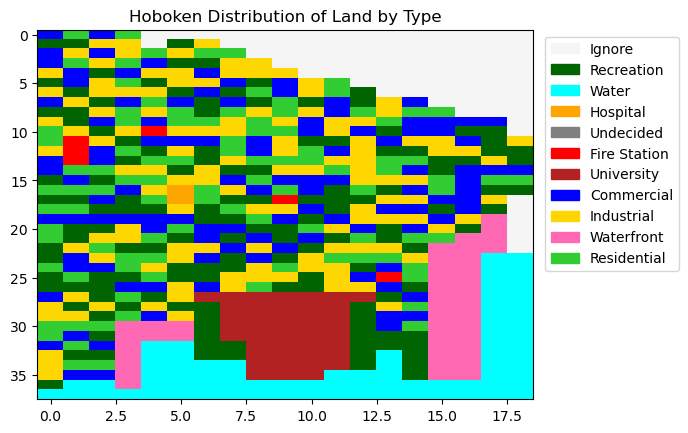

Weights: {'r': [2.778465885773809, 2.6241531329125873, 2.5993655233500164, 2.8986187179716545, 0.517681713083735, 0.06511533653836643], 'c': [0.6881703261500193, 2.829503761370818, 1.5120248417178712, 1.5818712330856108, 0.23946654046860005], 'i': [1.6704178976307777, 2.924428686148546, 0.599952953775573, 1.2348617506929935]}


Highest fitness score: 0.5975412271121446


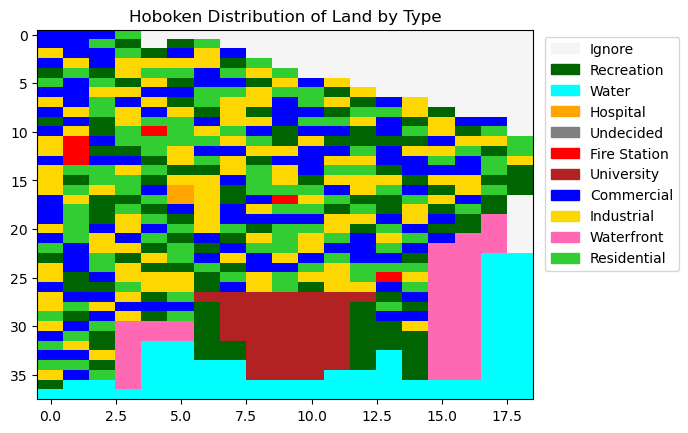

Weights: {'r': [2.1406449179557887, 2.2500815812381694, 0.05602061853850704, 1.033198044689339, 1.930271972283736, 1.9698843130817218], 'c': [1.2240301910035294, 2.885287746126938, 0.2001806366793144, 2.6923577527606493, 0.03367163998245559], 'i': [2.5217732200038223, 0.5869961082895198, 0.8115824763754564, 0.6071135470613441]}


Highest fitness score: 0.46030821412521994


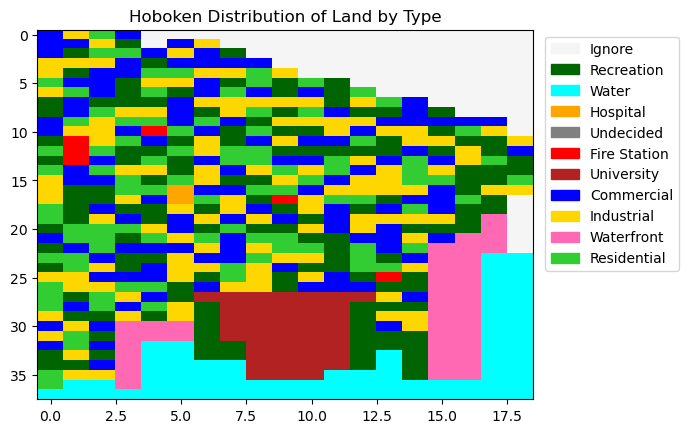

Weights: {'r': [2.836191230338923, 1.1135370461359388, 2.625560790523421, 2.6653699709937264, 2.906652792447046, 0.32541657546974057], 'c': [2.931755043724575, 1.4040408323478095, 2.487846790522082, 2.228054223744046, 2.5409230446308957], 'i': [1.9232102464556502, 1.548305108068262, 2.9698692866382626, 1.7508572053482832]}


Highest fitness score: 0.7378270954222561


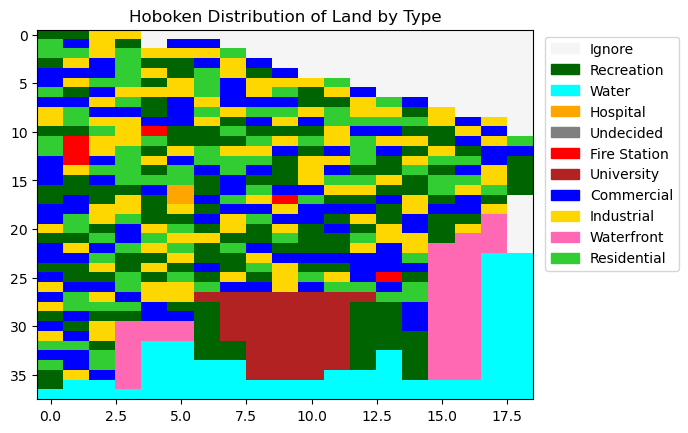

In [ ]:
weights = {
        'r':[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        'c':[1.0, 1.0, 1.0, 1.0, 1.0],
        'i':[1.0, 1.0, 1.0, 1.0]
    }

gens = 10
print(f'Weights: {weights}\n')
best_map = show_best_map(weights, gens, show_original=True)


for _ in range(5):
    for cells in weights: 
        new_weights = [random.uniform(0, 3) for _ in range(len(weights[cells]))]
        weights[cells] = new_weights
    print(f'Weights: {weights}\n')
    best_map = show_best_map(weights, gens)